In [8]:
from settings import (
    COMPLETIONS_MODEL,
    API_EXCHANGE_VERSION,
    API_BASE_URL,
    
    EMBEDDINGS_MODEL,
    EMBEDDINGS_BASE_URL,
    TOKEN_ID
)
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding

In [10]:
### Setting up llm and embed model


llm = AzureOpenAI(
    engine=COMPLETIONS_MODEL,
    api_key=TOKEN_ID,
    api_version=API_EXCHANGE_VERSION,
    azure_endpoint=f"{API_BASE_URL}/api"
)

embed_model = AzureOpenAIEmbedding(
    engine=EMBEDDINGS_MODEL,
    api_key=TOKEN_ID,
    api_version=API_EXCHANGE_VERSION,
    azure_endpoint=f"{EMBEDDINGS_BASE_URL}/api"
)

In [12]:
from utils import get_doc_tools
from llama_index.core import Settings

Settings.llm = llm
Settings.embed_model = embed_model

vector_tool, summary_tool = get_doc_tools("data/metagpt.pdf", "metagpt")

### Agent tools

#### Agent Worker (Responsible for executing the next step)

**Task Reasoning and execution**:

**Tools**:
- Vector Tool
- Summary Tool

LLM:
- LLM to use

#### Agent Runner (Task dispatcher)

**Agent Task Orchestrator**:

**Agent State** - mapping from task_id to taskstate
**TaskState**:
- Task
- Completed steps
- step queue

**Memory**: Conversation memory

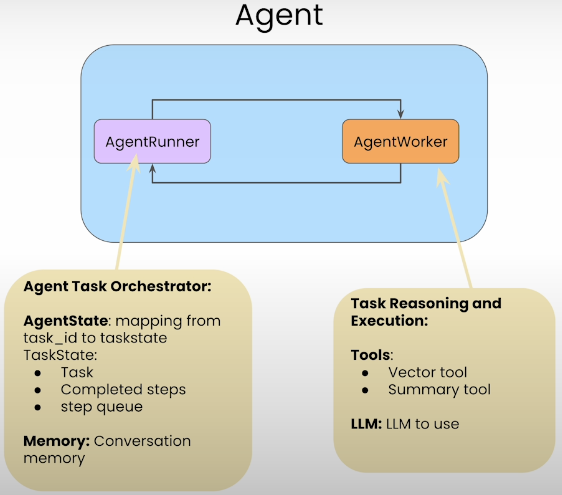

In [27]:
from IPython.display import Image

Image('img/agent_runner_worker.png')

In [19]:
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.core.agent import (
    FunctionCallingAgentWorker,
    AgentRunner
)

agent_worker = FunctionCallingAgentWorker.from_tools(
    [vector_tool, summary_tool],
    llm=llm,
    verbose=True
)

agent = AgentRunner(agent_worker)

In [20]:
response = agent.query(
    "Tell me about the agent roles in MetaGPT, "
    "and then how they communicate with one another."
)

Added user message to memory: Tell me about the agent roles in MetaGPT, and then how they communicate with one another.
=== Calling Function ===
Calling function: vector_tool_metagpt with args: {"query": "agent roles in MetaGPT"}
=== Function Output ===
The roles in MetaGPT include Product Manager, Architect, Project Manager, Engineer, and QA Engineer. These roles are specified in the software company within the MetaGPT framework. Each role has its own specialization and contributes specialized outputs tailored to specific tasks.
=== Calling Function ===
Calling function: vector_tool_metagpt with args: {"query": "communication between agents in MetaGPT"}
=== Function Output ===
Agents in MetaGPT communicate through structured messages using a shared message pool. They publish their structured messages in the pool and can also subscribe to relevant messages based on their profiles. This communication protocol enhances role communication efficiency and allows agents to obtain directional

In [21]:
print(response.source_nodes[0].get_content(metadata_mode='all'))

page_label: 9
file_name: metagpt.pdf
file_path: data\metagpt.pdf
file_type: application/pdf
file_size: 16911937
creation_date: 2024-05-31
last_modified_date: 2024-05-31

Preprint
Table 2: Comparison of capabilities for MetaGPT and other approaches. ‘!’ indicates the
presence of a specific feature in the corresponding framework, ‘ %’ its absence.
Framework Capabiliy AutoGPT LangChain AgentVerse ChatDev MetaGPT
PRD generation % % % % !
Tenical design genenration % % % % !
API interface generation % % % % !
Code generation ! ! ! ! !
Precompilation execution % % % % !
Role-based task management % % % ! !
Code review % % ! ! !
Table 3: Ablation study on roles. ‘#’ denotes ‘The number of’, ‘Product’ denotes ‘Product man-
ager’, and ‘Project’ denotes ‘Project manager’. ‘ !’ indicates the addition of a specific role. ‘Revi-
sions’ refers to ‘Human Revision Cost’.
Engineer Product Architect Project #Agents #Lines Expense Revisions Executability
! % % % 1 83.0 $ 0.915 10 1.0
! ! % % 2 112.0 $ 1.

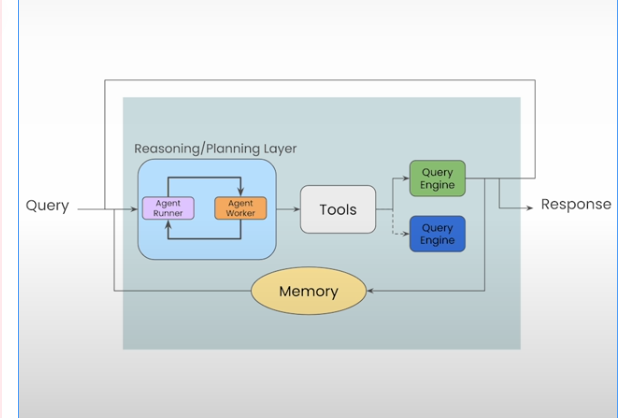

In [25]:
from IPython.display import Image
Image('img/agents_execution_loop.png')

In [28]:
response = agent.chat("Tell me about the evaluation datasets used.")

Added user message to memory: Tell me about the evaluation datasets used.
=== Calling Function ===
Calling function: vector_tool_metagpt with args: {"query": "evaluation datasets used in MetaGPT"}
=== Function Output ===
The evaluation datasets used in MetaGPT are the HumanEval benchmark and the MBPP benchmark.
=== LLM Response ===
The evaluation datasets used in MetaGPT are the HumanEval benchmark and the MBPP benchmark.


In [29]:
response = agent.chat("Tell me the results over one of the above datasets.")

Added user message to memory: Tell me the results over one of the above datasets.
=== Calling Function ===
Calling function: vector_tool_metagpt with args: {"query": "results over HumanEval benchmark in MetaGPT"}
=== Function Output ===
MetaGPT achieves a pass rate of 85.9% in the HumanEval benchmark.
=== Calling Function ===
Calling function: vector_tool_metagpt with args: {"query": "results over MBPP benchmark in MetaGPT"}
=== Function Output ===
MetaGPT achieves a pass rate of 85.9% over the MBPP benchmark.
=== LLM Response ===
MetaGPT achieves a pass rate of 85.9% over both the HumanEval benchmark and the MBPP benchmark.


### Traceability

### Agent Control

The key benefits:
- **Decoupling of Task Creation and Execution**:
    - Users gain the flexibility to schedule task execution according to their needs
- **Enhanced Debuggability**:
    - Offers deeper insights into each step of the execution process improving troubleshooting capabilities
- **Steerability**:
  -   Allows users to directly modify intermediate steps and incorporate human feedback for refined control

### Low-level API: Debuggability and Control

In [30]:
agent_worker = FunctionCallingAgentWorker.from_tools(
    [vector_tool, summary_tool],
    llm=llm,
    verbose=True
)
agent = AgentRunner(agent_worker)

In [31]:
task = agent.create_task(
    "Tell me about the agent roles in MetaGPT and then how they communicate with one another."
)

In [32]:
step_output = agent.run_step(task.task_id)

Added user message to memory: Tell me about the agent roles in MetaGPT and then how they communicate with one another.
=== Calling Function ===
Calling function: vector_tool_metagpt with args: {"query": "agent roles in MetaGPT"}
=== Function Output ===
The roles in MetaGPT include Product Manager, Architect, Project Manager, Engineer, and QA Engineer. These roles are specified in the software company within the MetaGPT framework. Each role has its own specialization and contributes specialized outputs tailored to specific tasks.


In [33]:
completed_steps = agent.get_completed_steps(task.task_id)
print(f"Num completed for task {task.task_id}: {len(completed_steps)}")
print(completed_steps[0].output.sources[0].raw_output)

Num completed for task e879be32-7ad6-44bb-b781-95a4e81329e6: 1
The roles in MetaGPT include Product Manager, Architect, Project Manager, Engineer, and QA Engineer. These roles are specified in the software company within the MetaGPT framework. Each role has its own specialization and contributes specialized outputs tailored to specific tasks.


In [36]:
upcoming_steps = agent.get_upcoming_steps(task.task_id)
print(f"Num upcoming steps for task {task.task_id}: {len(upcoming_steps)}")
upcoming_steps[0]

Num upcoming steps for task e879be32-7ad6-44bb-b781-95a4e81329e6: 1


TaskStep(task_id='e879be32-7ad6-44bb-b781-95a4e81329e6', step_id='e68340af-99ae-4caa-8cc4-fed6fd56cbef', input=None, step_state={}, next_steps={}, prev_steps={}, is_ready=True)

In [37]:
step_output = agent.run_step(
    task.task_id, input="What about how agents share information?"
)

Added user message to memory: What about how agents share information?
=== Calling Function ===
Calling function: vector_tool_metagpt with args: {"query": "how do agents share information in MetaGPT"}
=== Function Output ===
Agents in MetaGPT share information through a shared message pool, where they publish structured messages and can access messages from other agents. Additionally, they utilize a subscription mechanism based on their role-specific interests to extract relevant information. This allows them to select information to follow based on their role profiles, enhancing communication efficiency.


In [38]:
step_output = agent.run_step(task.task_id)
print(step_output.is_last)

=== LLM Response ===
In MetaGPT, agents share information through a shared message pool. They publish structured messages and can access messages from other agents. This shared message pool serves as a central hub for communication and information exchange among the agents.

Additionally, agents in MetaGPT utilize a subscription mechanism based on their role-specific interests. Each agent has a profile that specifies their areas of expertise and the types of information they are interested in. They subscribe to relevant topics or categories of information within the shared message pool.

By subscribing to specific topics, agents can filter and extract the information that is most relevant to their roles and responsibilities. This helps to enhance communication efficiency and ensure that agents receive the information they need to perform their tasks effectively.

Overall, the shared message pool and the subscription mechanism enable agents in MetaGPT to share and access information in 

In [39]:
response = agent.finalize_response(task.task_id)

In [40]:
print(str(response))

In MetaGPT, agents share information through a shared message pool. They publish structured messages and can access messages from other agents. This shared message pool serves as a central hub for communication and information exchange among the agents.

Additionally, agents in MetaGPT utilize a subscription mechanism based on their role-specific interests. Each agent has a profile that specifies their areas of expertise and the types of information they are interested in. They subscribe to relevant topics or categories of information within the shared message pool.

By subscribing to specific topics, agents can filter and extract the information that is most relevant to their roles and responsibilities. This helps to enhance communication efficiency and ensure that agents receive the information they need to perform their tasks effectively.

Overall, the shared message pool and the subscription mechanism enable agents in MetaGPT to share and access information in a structured and effi